# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
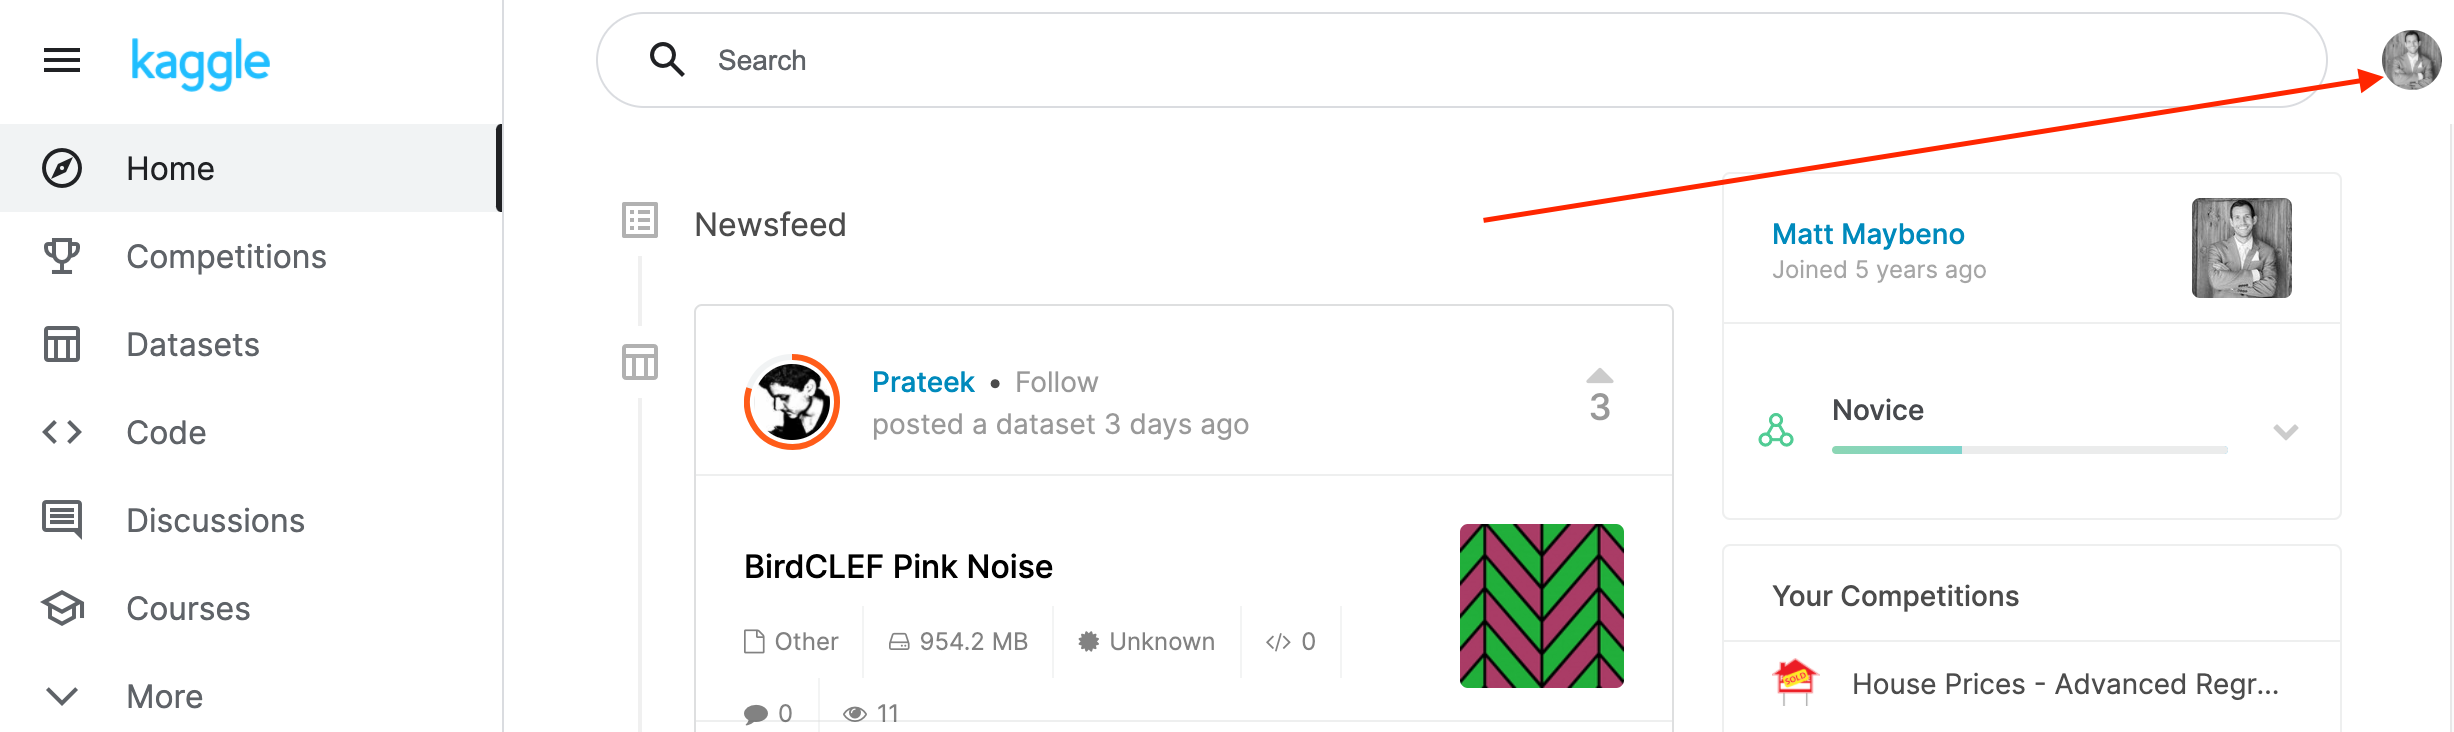
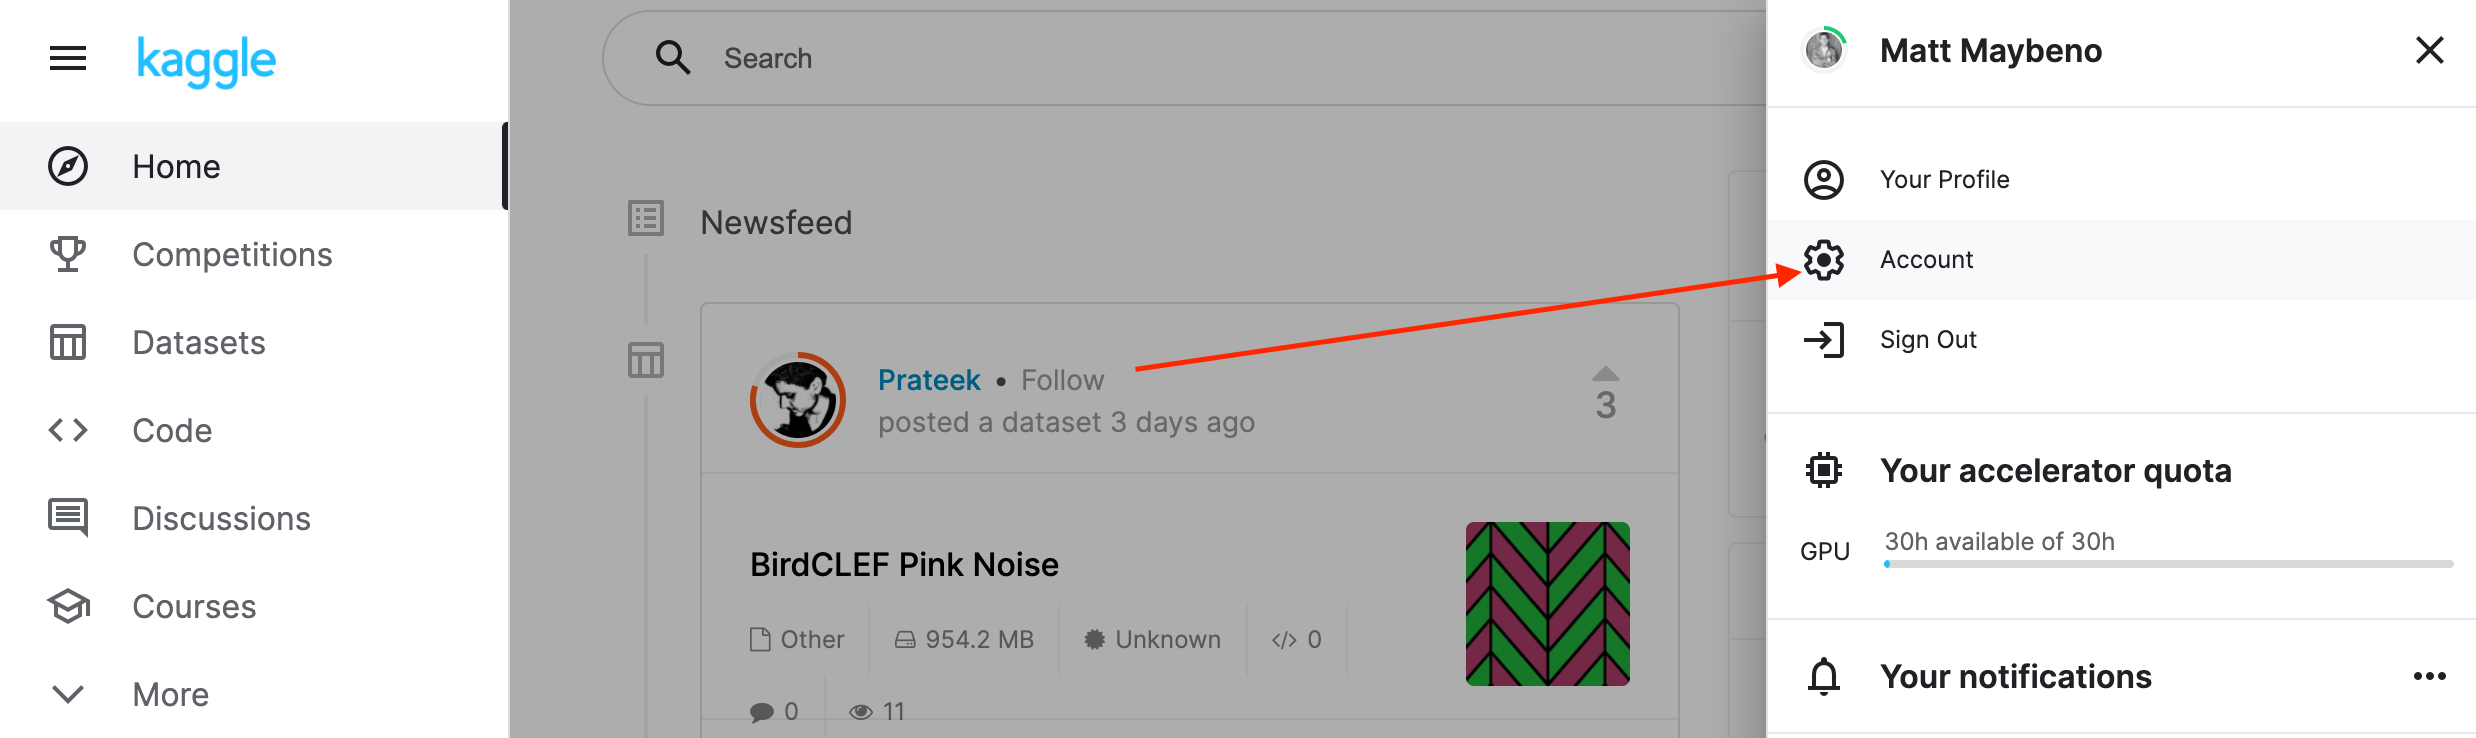
2. Scroll down to API and click Create New API Token.
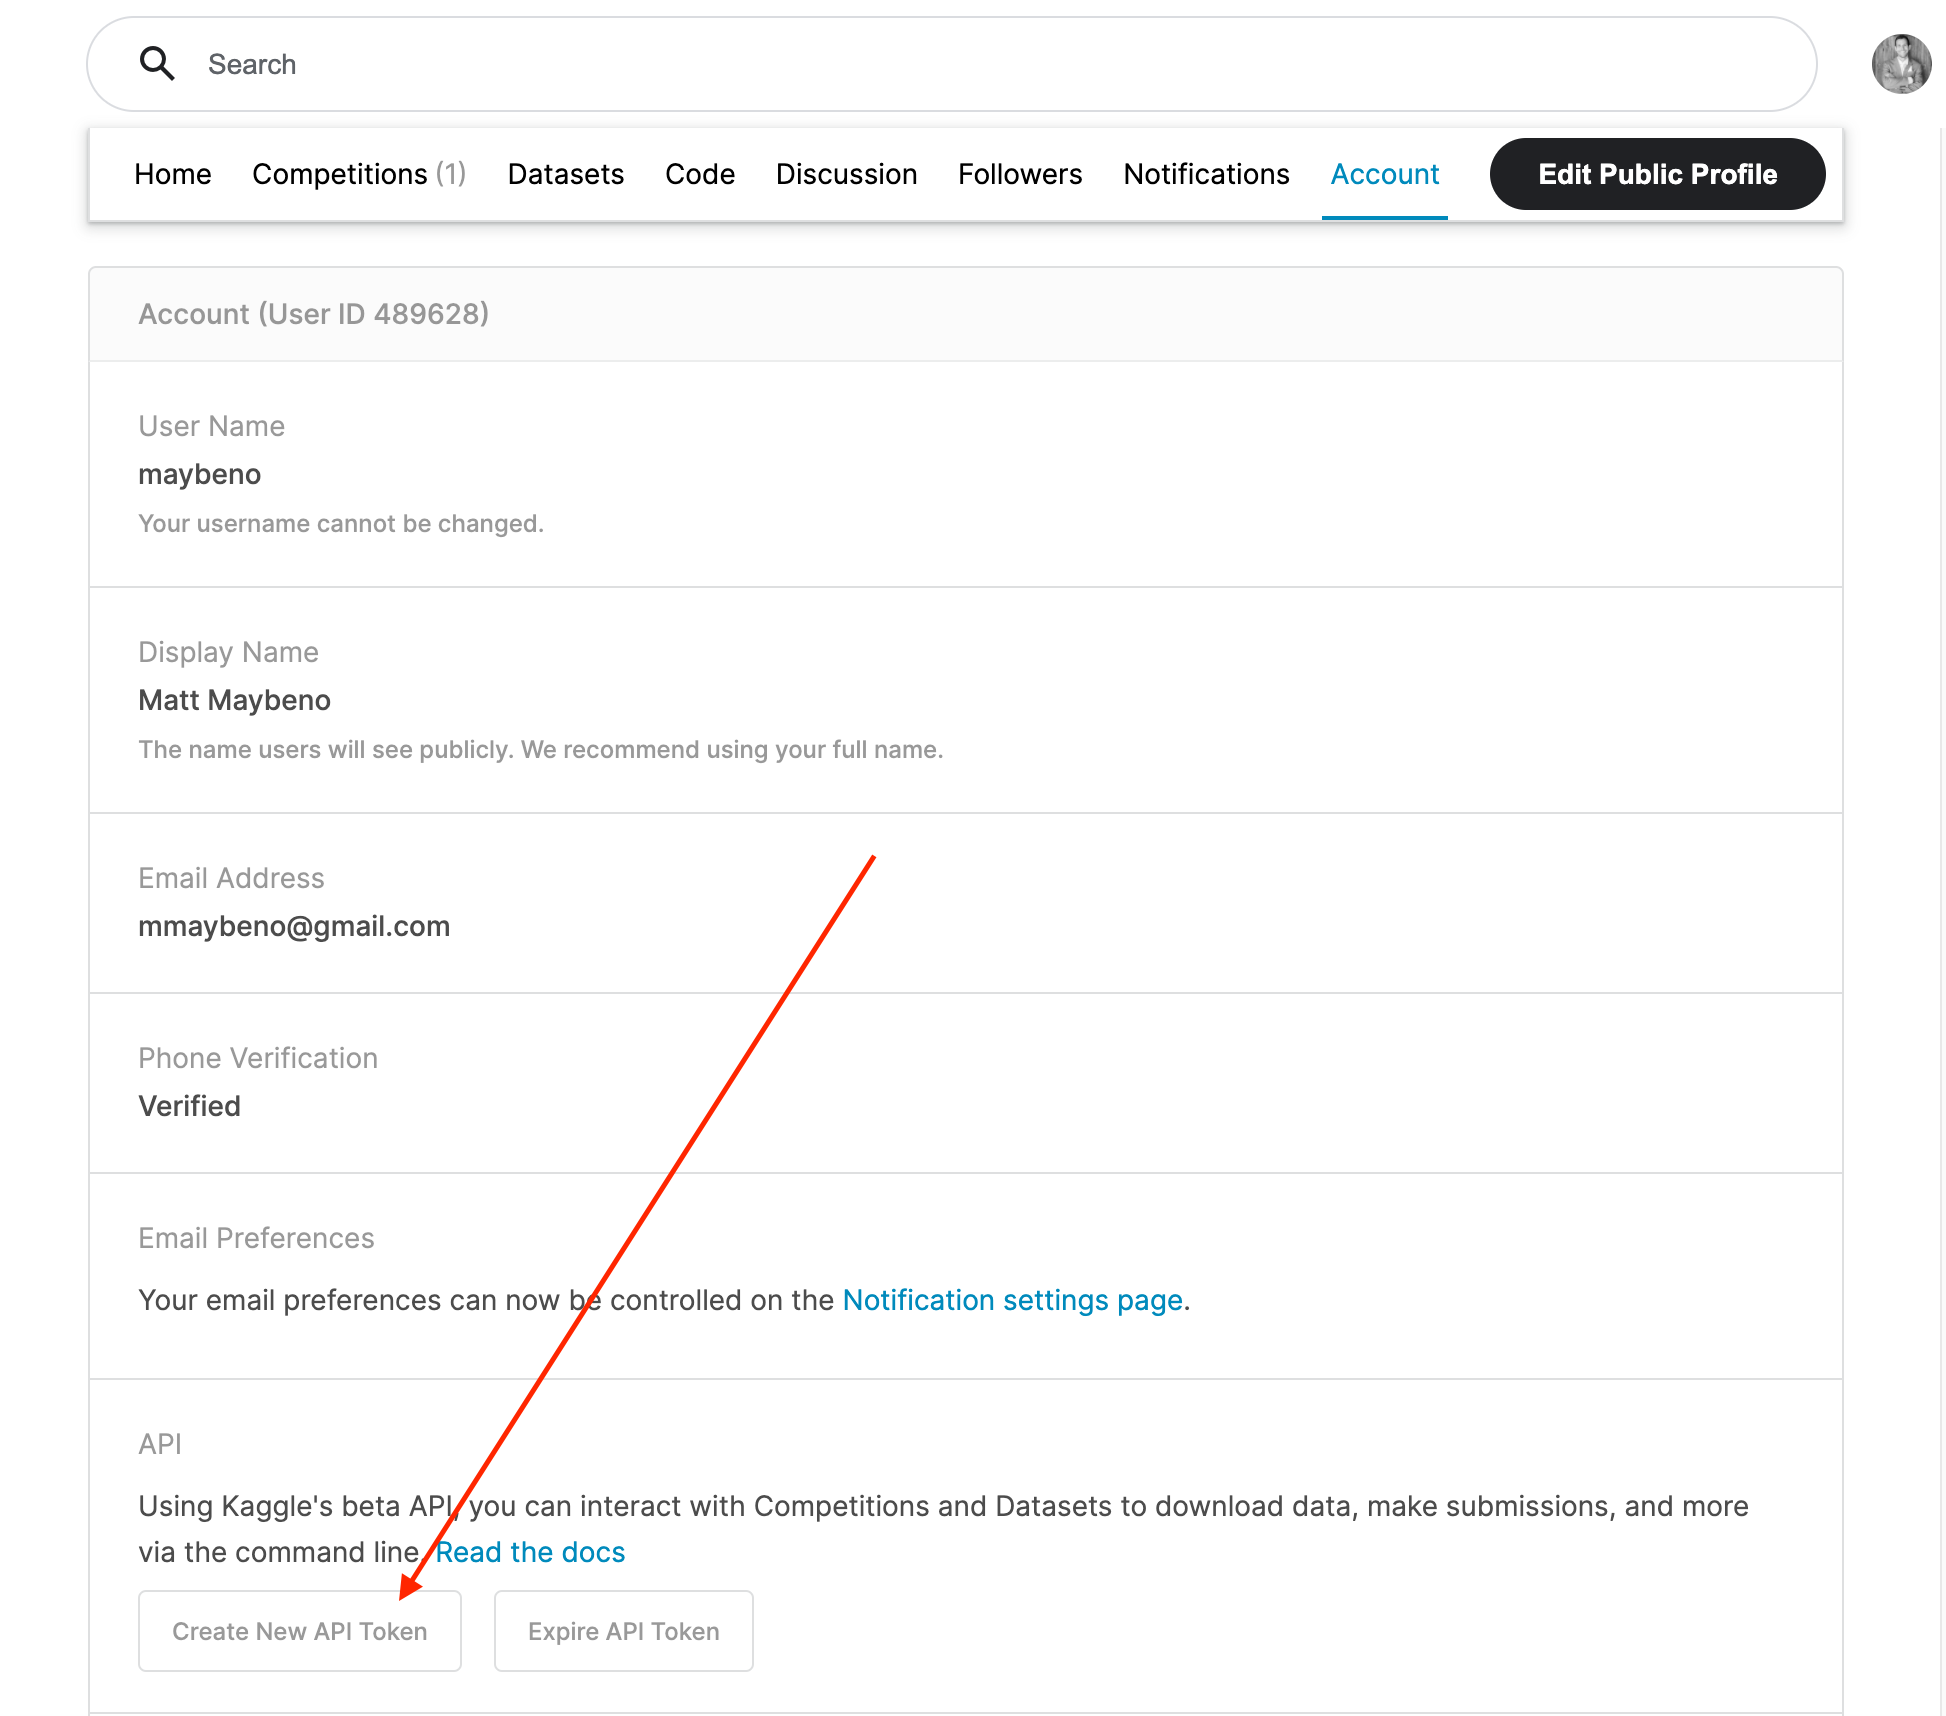
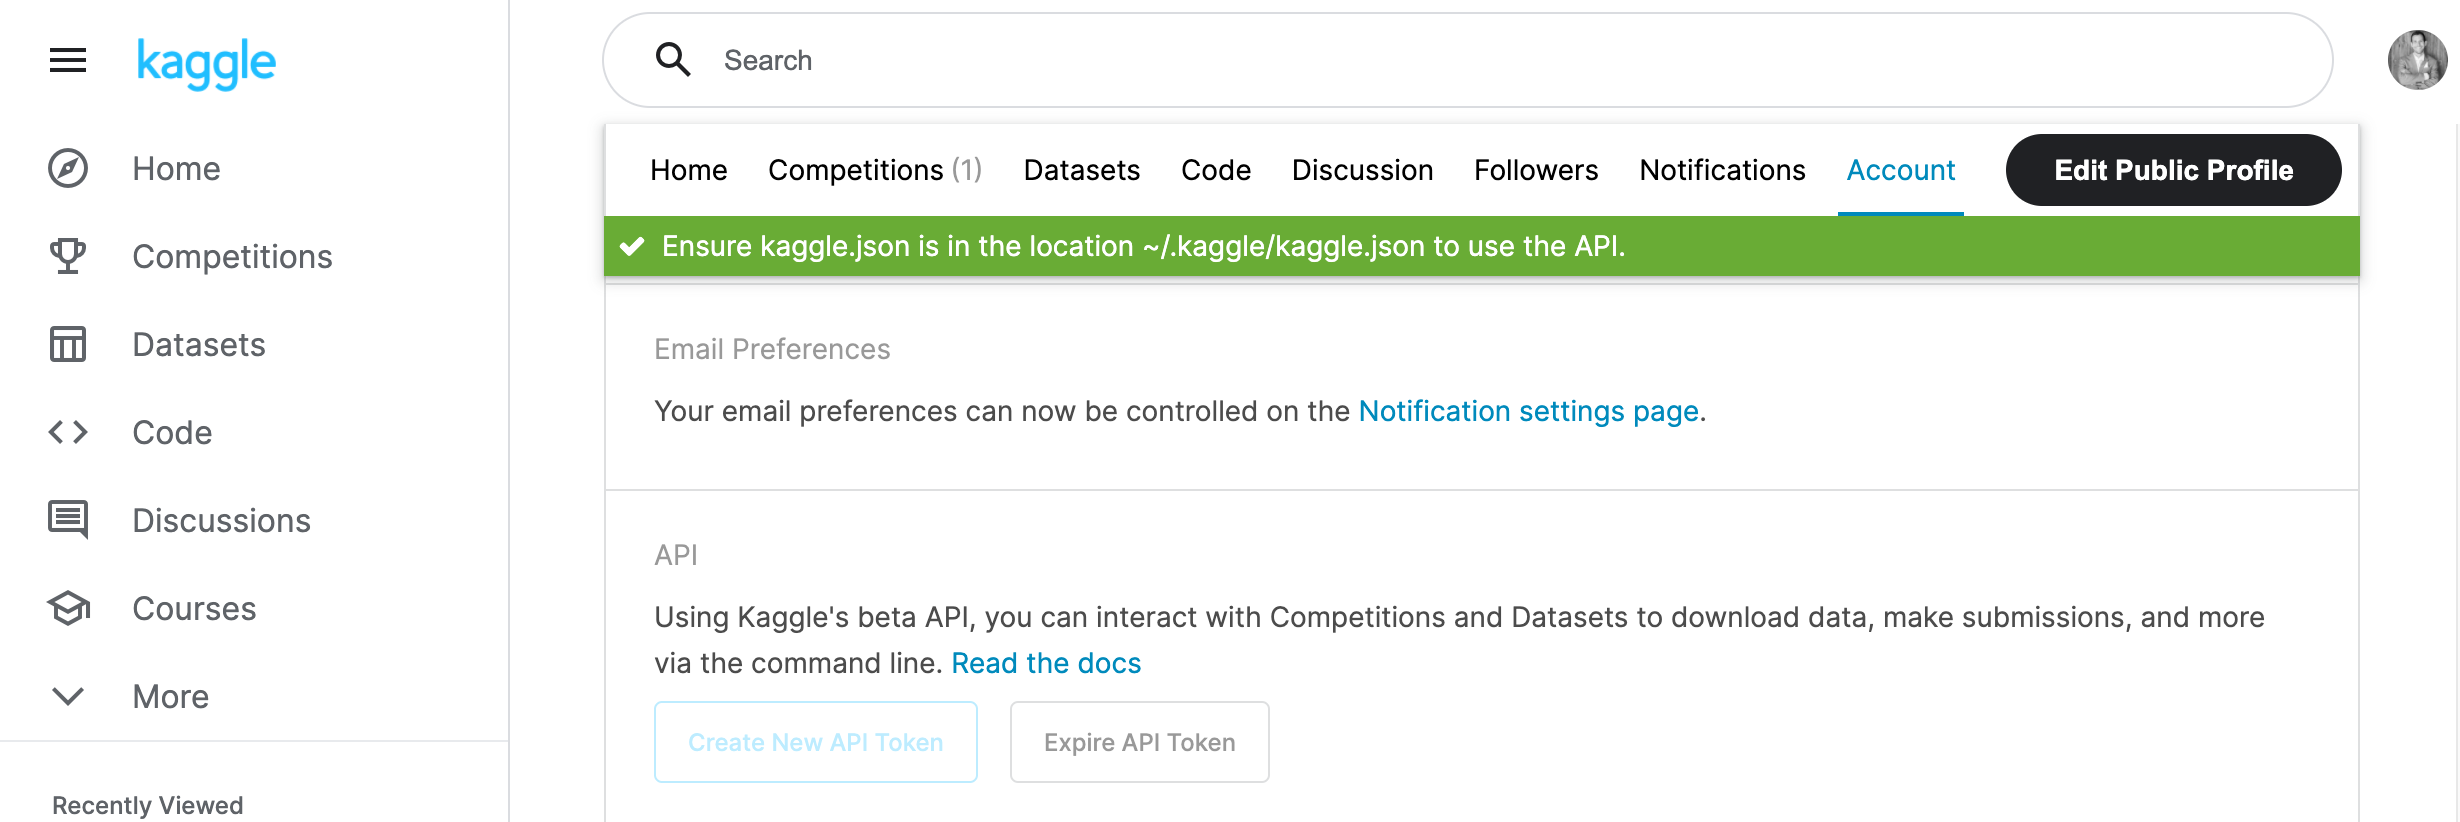
3. Open up `kaggle.json` and use the username and key.
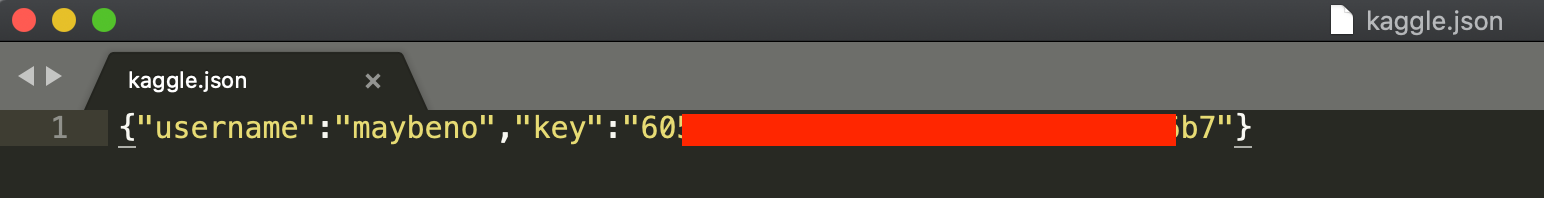

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install -U "mxnet<2.0.0" bokeh==2.0.1
# !pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: /root: Read-only file system
touch: /root/.kaggle/kaggle.json: No such file or directory
chmod: /root/.kaggle/kaggle.json: No such file or directory


In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
# kaggle_username = "mbalcerzak"
# kaggle_key = "XXXXX"

# # Save API token the kaggle.json file
# with open("/root/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms
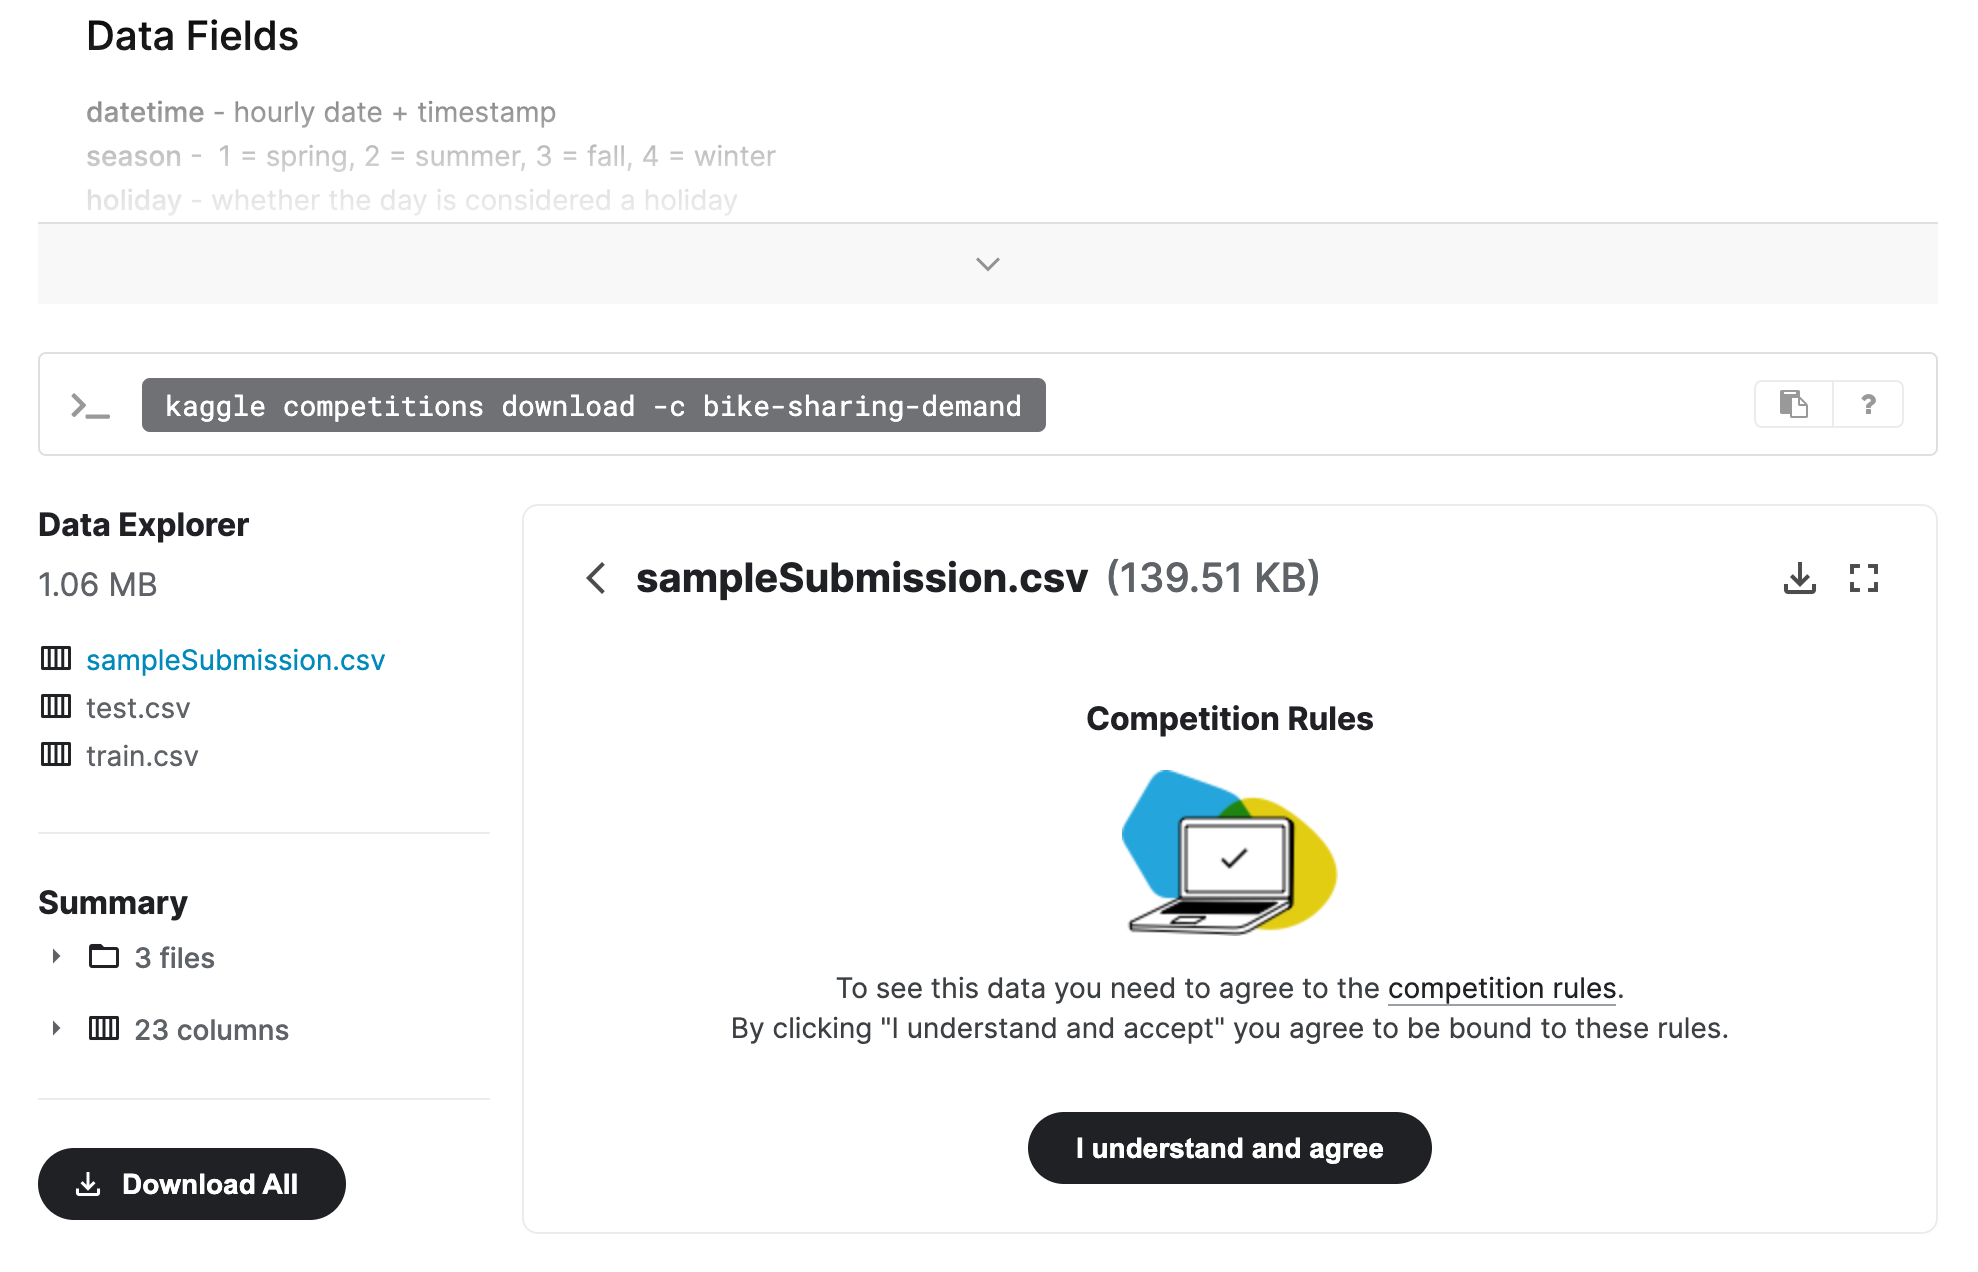

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sb

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


**`datetime`** - hourly date + timestamp  
**`season`** - 1 = spring, 2 = summer, 3 = fall, 4 = winter  
**`holiday`** - whether the day is considered a holiday  
**`workingday`** - whether the day is neither a weekend nor holiday  
**`weather`** -  

1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

**`temp`** - temperature in Celsius  
**`atemp`** - "feels like" temperature in Celsius  
**`humidity`** - relative humidity  
**`windspeed`** - wind speed  
**`casual`** - number of non-registered user rentals initiated (ignore, since absent in test data)  
**`registered`** - number of registered user rentals initiated (ignore, since absent in test data)  
**`count`** - number of total rentals  

In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [10]:
# Check for null values
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [11]:
# Same thing as train and test dataset
submission = pd.read_csv("data/sampleSubmission.csv", parse_dates=["datetime"])
submission.head(3)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
eval_metric = "root_mean_squared_error"
pred_label = "count"

In [13]:
cols = ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']

In [14]:
predictor = TabularPredictor(
                label=pred_label, 
                problem_type= 'regression',
                eval_metric=eval_metric
            ).fit(
                train_data=train[cols], 
                time_limit=600, 
                presets="best_quality"
                )

No path specified. Models will be saved in: "AutogluonModels/ag-20230809_134832/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230809_134832/"
AutoGluon Version:  0.8.2
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Thu Jun  8 22:22:19 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8103
Disk Space Avail:   15.15 GB / 245.11 GB (6.2%)
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    376.83 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to m

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.427729       2.673790  429.281996                0.000472           0.175356            3       True         16
1   NeuralNetFastAI_BAG_L2  -51.377128       1.916484  251.788508                0.704448          49.818230            2       True         13
2   RandomForestMSE_BAG_L2  -53.800632       1.316610  203.848974                0.104574           1.878697            2       True         10
3    NeuralNetTorch_BAG_L2  -53.898406       1.748126  376.805833                0.536090         174.835556            2       True         15
4          CatBoost_BAG_L2  -54.423881       1.371221  246.951147                0.159185          44.980870            2       True         11
5     ExtraTreesMSE_BAG_L2  -54.579821       1.328206  202.574157                0.116170           0.603880            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-50.427729,2.673790,429.281996,0.000472,0.175356,3,True,16
1,NeuralNetFastAI_BAG_L2,-51.377128,1.916484,251.788508,0.704448,49.818230,2,True,13
2,RandomForestMSE_BAG_L2,-53.800632,1.316610,203.848974,0.104574,1.878697,2,True,10
3,NeuralNetTorch_BAG_L2,-53.898406,1.748126,376.805833,0.536090,174.835556,2,True,15
4,CatBoost_BAG_L2,-54.423881,1.371221,246.951147,0.159185,44.980870,2,True,11
5,ExtraTreesMSE_BAG_L2,-54.579821,1.328206,202.574157,0.116170,0.603880,2,True,12
6,KNeighborsDist_BAG_L1,-84.146423,0.015985,0.016496,0.015985,0.016496,1,True,2
7,WeightedEnsemble_L2,-84.146423,0.016351,0.237475,0.000366,0.220979,2,True,9
8,KNeighborsUnif_BAG_L1,-101.588176,0.016708,0.021285,0.016708,0.021285,1,True,1
9,RandomForestMSE_BAG_L1,-118.547757,0.081509,0.839910,0.081509,0.839910,1,True,3


### Create predictions from test dataset

In [16]:
predictions = predictor.predict(test)
predictions.head()

0    24.741682
1    41.928223
2    46.947235
3    47.284203
4    49.962044
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       99.295975
std        88.948326
min         0.894322
25%        19.535973
50%        65.651642
75%       167.930267
max       353.739380
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
predictions.isnull().sum()

0

In [19]:
# Set them to zero
def set_neg_to_zero(x):
    return [y if y>=0 else 0 for y in x]

predictions_baseline = set_neg_to_zero(predictions)

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions_baseline
submission.to_csv("submission_baseline.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission_baseline.csv -m "baseline submission"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 283kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_baseline.csv      2023-08-09 13:58:04  baseline submission                complete  1.82808      1.82808       
submission_new_hpo.csv       2023-08-09 13:34:15  new features with hyperparameters  complete  0.54747      0.54747       
submission_new_features.csv  2023-08-08 22:31:15  new features                       complete  0.46759      0.46759       
submission_baseline.csv      2023-08-08 20:44:03  baseline submission                complete  1.87100      1.87100       


#### Initial score of: 1.82602

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

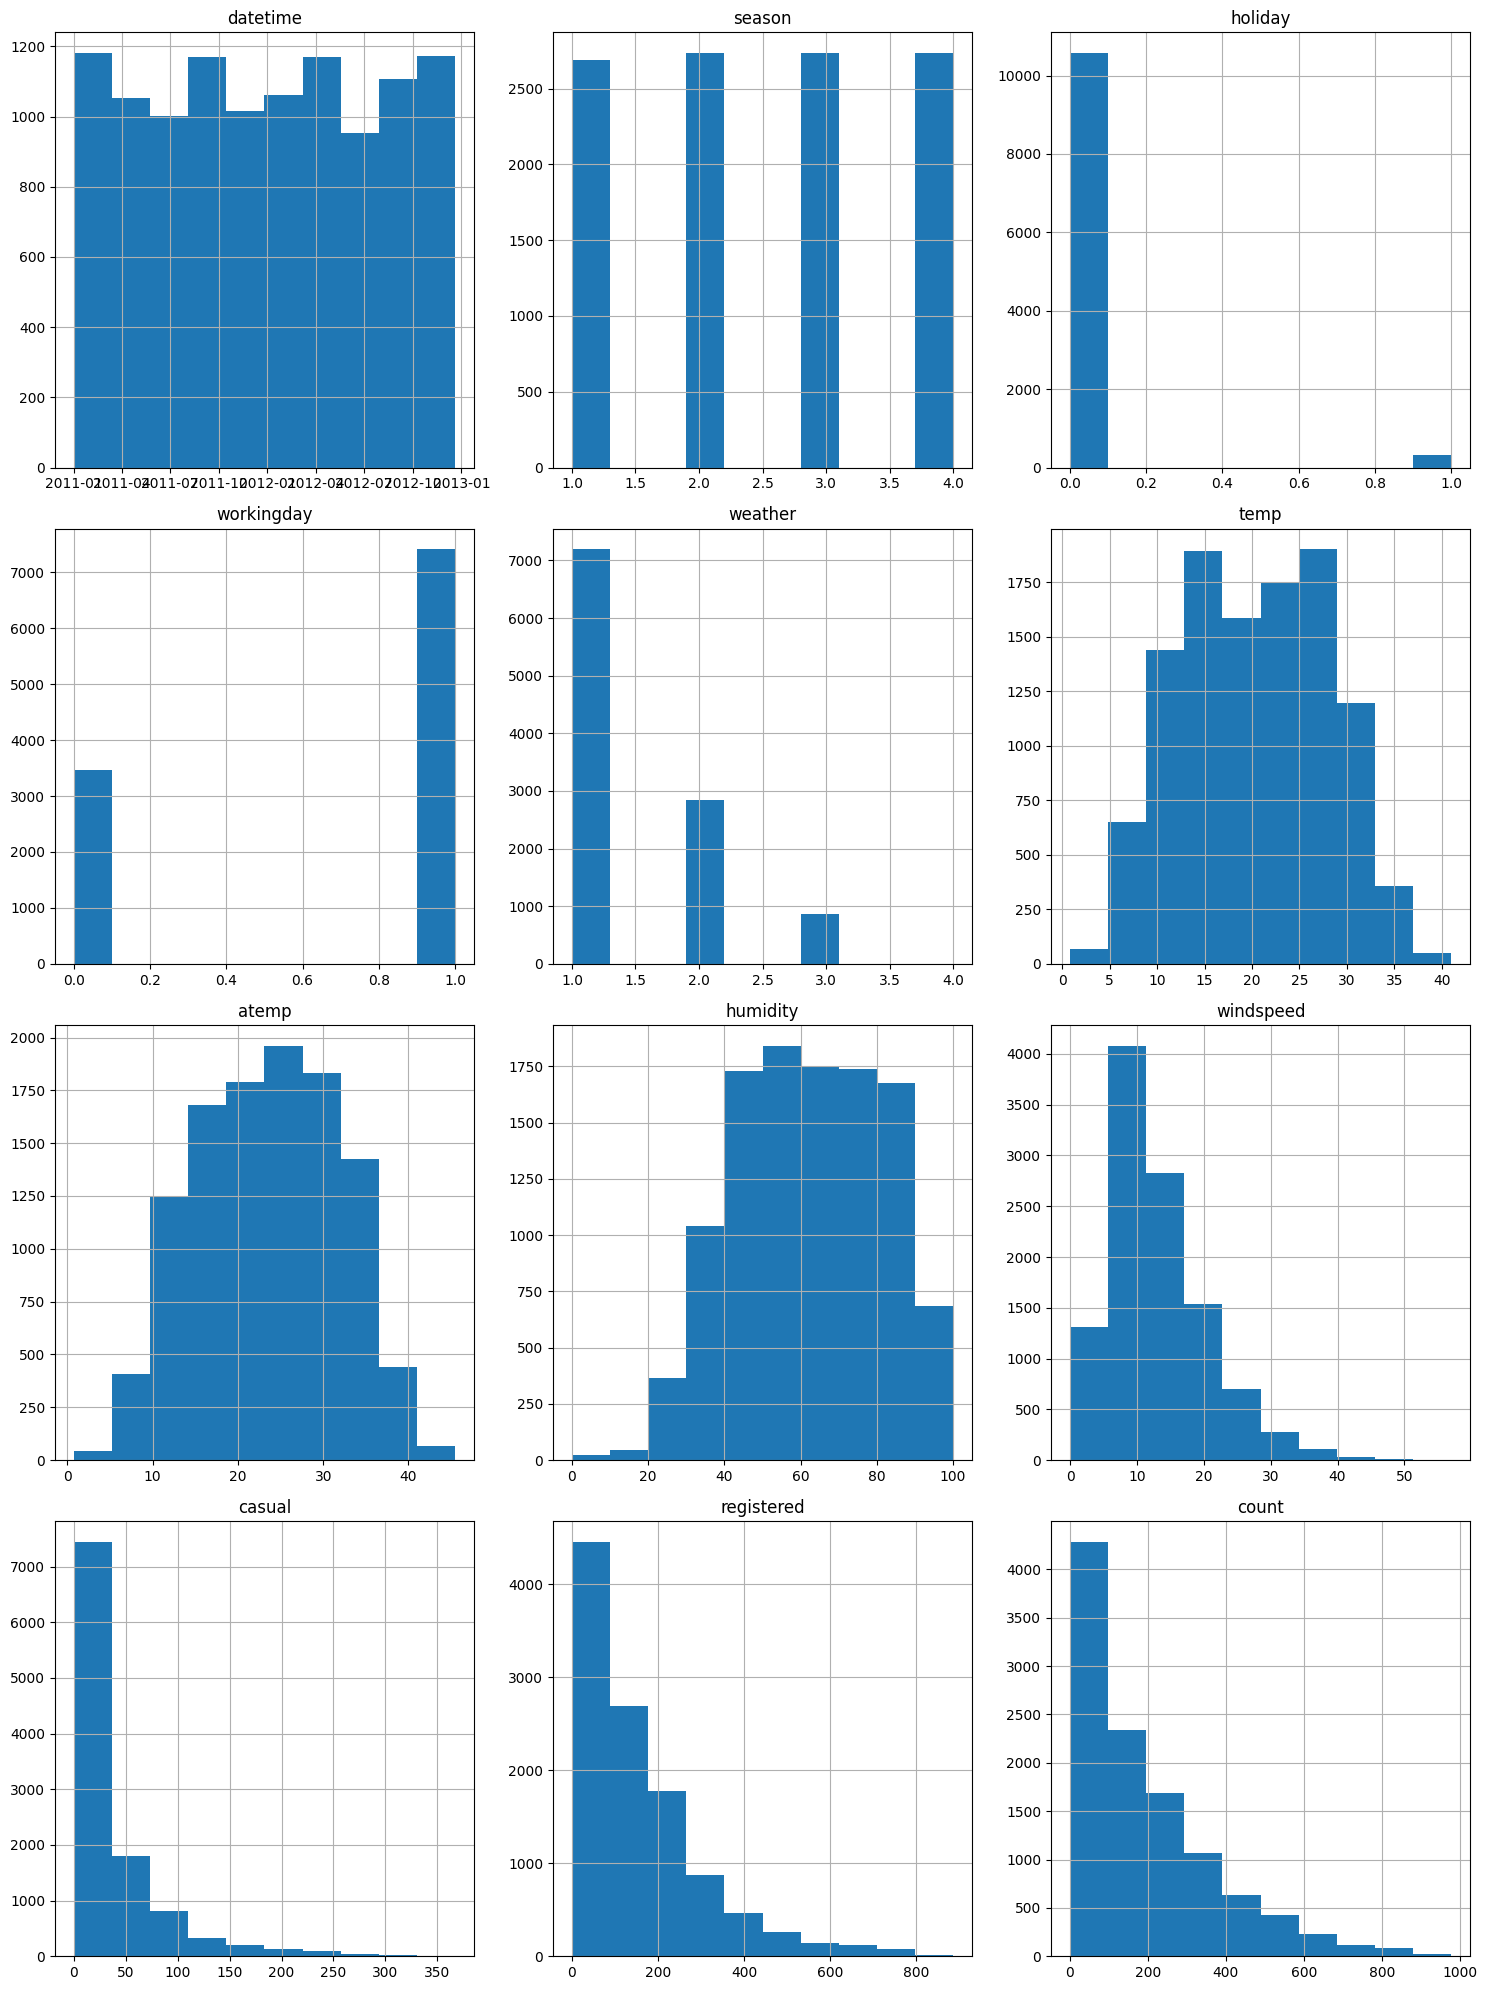

In [23]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,20))

plt.tight_layout()
plt.show()

/var/folders/6s/dz8bggdn2cvbxr_txvltwrz00000gn/T/ipykernel_96913/310826213.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()
/var/folders/6s/dz8bggdn2cvbxr_txvltwrz00000gn/T/ipykernel_96913/310826213.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


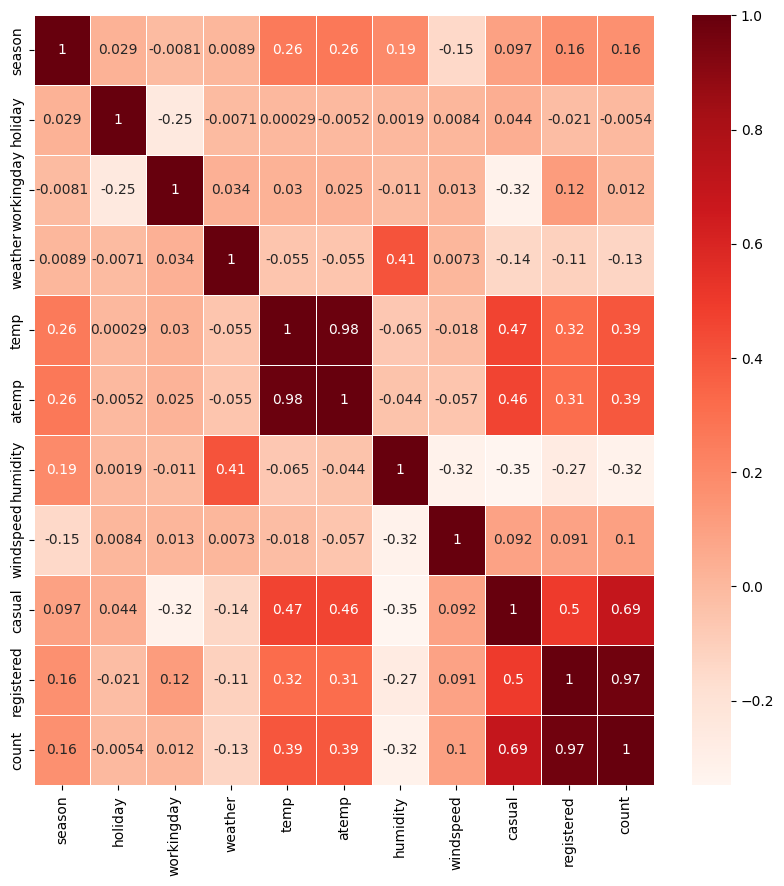

In [24]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(corr, annot=True, linewidths=.5, ax=ax, cmap="Reds")
fig.show()

### Observations

- `registered` and `casual` are highly positively correlated with the target variable `count` therefore it makes sense that the variables should be removed
- `atemp` and `temp` are highly positively correlated and we should keep only one of them in the final training dataset

In [25]:
# Create new features
train["hour"] = train["datetime"].dt.round("H").dt.hour
train["day"] = train["datetime"].dt.dayofweek
train["month"] = train["datetime"].dt.month
train["year"] = train["datetime"].dt.year

test["hour"] = test["datetime"].dt.round("H").dt.hour
test["day"] = test["datetime"].dt.dayofweek
test["month"] = test["datetime"].dt.month
test["year"] = test["datetime"].dt.year

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


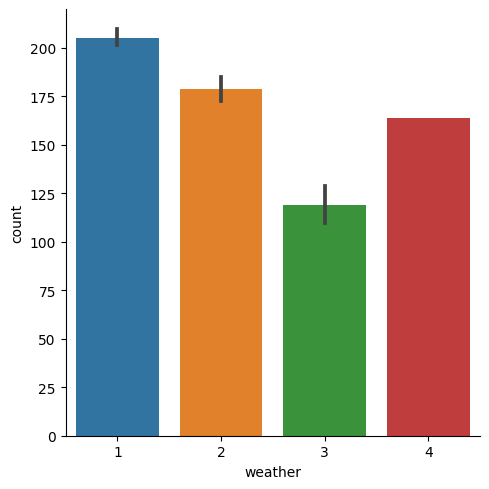

In [26]:
sb.catplot(train, x="weather", y="count", kind="bar")

Weather numbers explanation:

1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


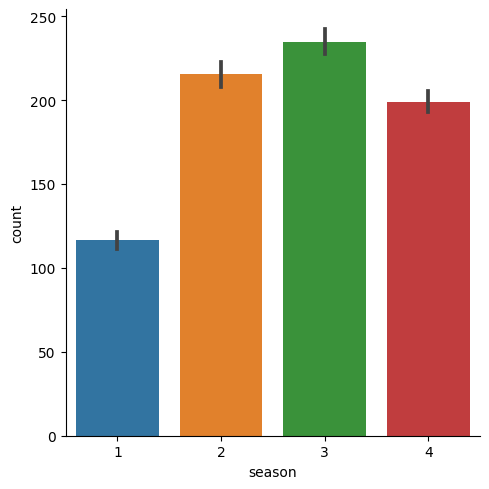

In [27]:
sb.catplot(train, x="season", y="count", kind="bar")

Does 

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


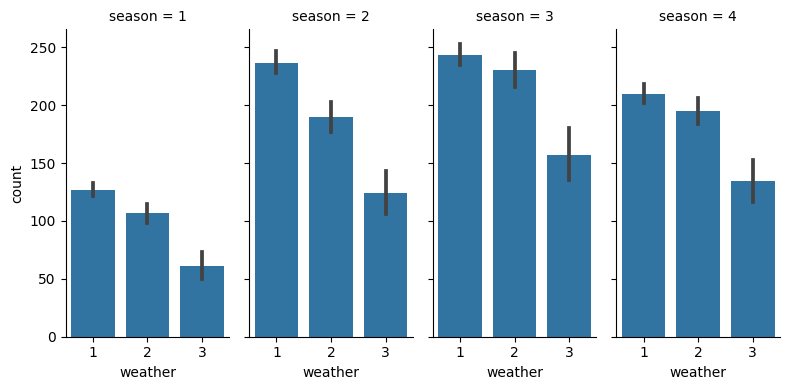

In [28]:
g = sb.FacetGrid(train, col="season", height=4, aspect=.5)
g.map(sb.barplot, "weather", "count")

In [29]:
from collections import Counter
Counter(train["weather"])

Counter({1: 7192, 2: 2834, 3: 859, 4: 1})

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


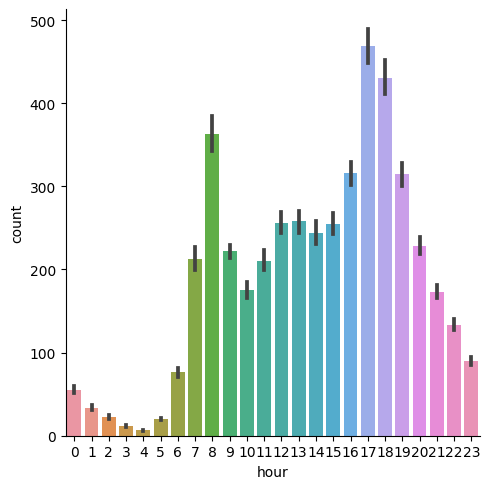

In [30]:
sb.catplot(train, x="hour", y="count", kind="bar")

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


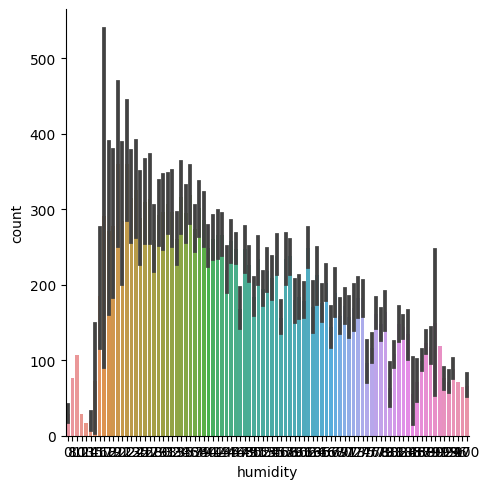

In [31]:
sb.catplot(train, x="humidity", y="count", kind="bar")

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


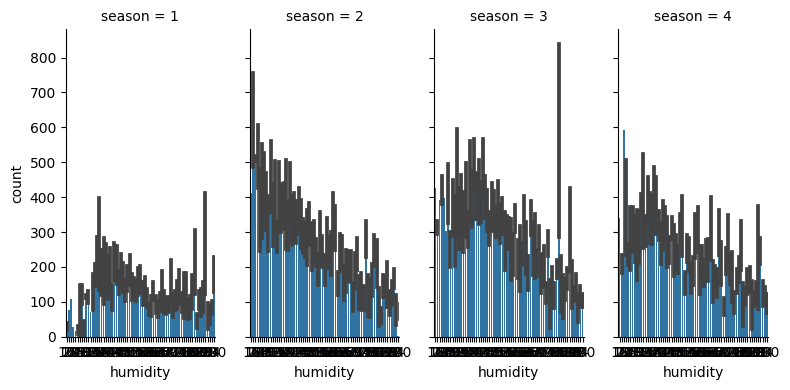

In [32]:
g = sb.FacetGrid(train, col="season", height=4, aspect=.5)
g.map(sb.barplot, "humidity", "count")

/Users/malgorzatabslcerzak/Documents/projects/nd009t-c1-intro-to-ml-project-starter/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


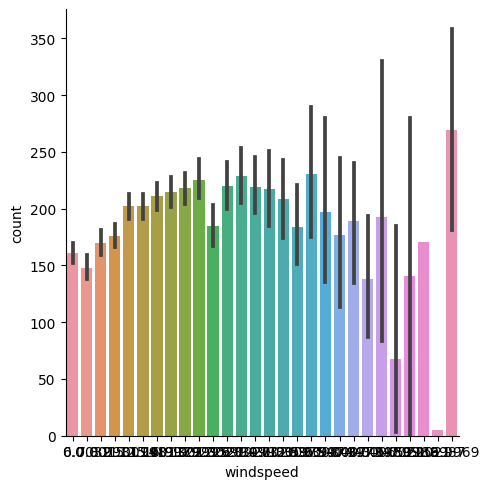

In [33]:
sb.catplot(train, x="windspeed", y="count", kind="bar")

In [34]:
# Add features from HOUR

time_category = pd.cut(
            train["hour"], 
            bins=[-1,4,7,10,15,19,25],
            labels=['night', 'early_morning', 'morning', 'lunch', 'afternoon','evening']
        )

train.insert(3, 'time_category', time_category)
train.head(3)

train["time_category"] = train["time_category"].astype("category")

# and apply the same treatment to TEST dataset

time_category_ts = pd.cut(
            test["hour"], 
            bins=[-1,4,7,10,15,19,25],
            labels=['night', 'early_morning', 'morning', 'lunch', 'afternoon','evening']
        )

test.insert(3, 'time_category', time_category_ts)
test["time_category"] = test["time_category"].astype("category")


In [35]:
cols_added_ft = [
    'season',
    'holiday',
    'workingday',
    'weather',
    'temp',
    'humidity',
    'windspeed',
    'count',
    'hour',
    'time_category',
    'day',
    'month',
    'year'
]

train = train[cols_added_ft]

In [36]:
train.head(3)

,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,time_category,day,month,year
0,1,0,0,1,9.84,81,0.0,16,0,night,5,1,2011
1,1,0,0,1,9.02,80,0.0,40,1,night,5,1,2011
2,1,0,0,1,9.02,80,0.0,32,2,night,5,1,2011


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [43]:
train = train.astype({"season":"category", "weather":"category"})
test = test.astype({"season":"category", "weather":"category"})

In [44]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,time_category,day,month,year
0,1,0,0,1,9.84,81,0.0,16,0,night,5,1,2011
1,1,0,0,1,9.02,80,0.0,40,1,night,5,1,2011
2,1,0,0,1,9.02,80,0.0,32,2,night,5,1,2011
3,1,0,0,1,9.84,75,0.0,13,3,night,5,1,2011
4,1,0,0,1,9.84,75,0.0,1,4,night,5,1,2011


array([[<Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>],
       [<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >, <Axes: >]],
      dtype=object)

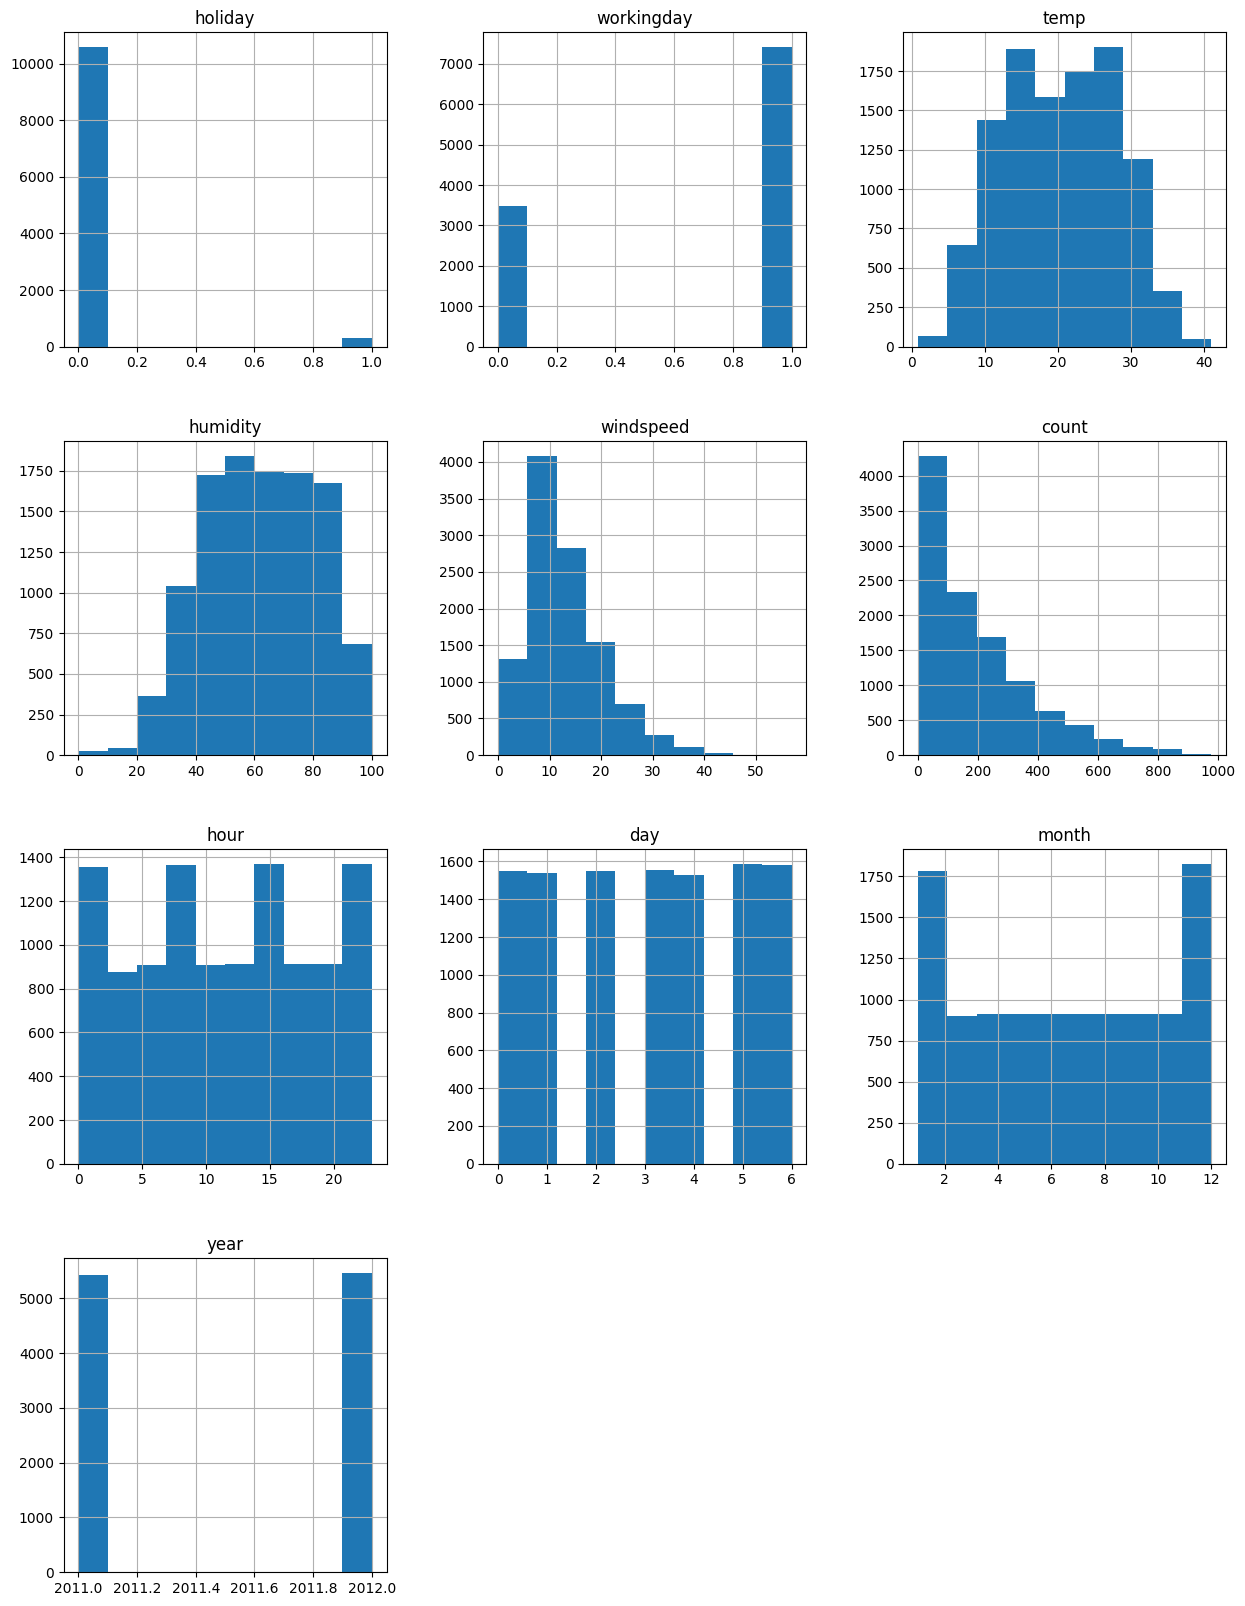

In [45]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))

## Step 5: Rerun the model with the same settings as before, just with more features

In [46]:
predictor_new_features = TabularPredictor(
                            label="count", 
                            problem_type= 'regression',
                            eval_metric="root_mean_squared_error"
                            ).fit(
                                train_data=train, 
                                time_limit=600, 
                                presets="best_quality"
                                )                                         

No path specified. Models will be saved in: "AutogluonModels/ag-20230809_141136/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230809_141136/"
AutoGluon Version:  0.8.2
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Thu Jun  8 22:22:19 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8103
Disk Space Avail:   14.70 GB / 245.11 GB (6.0%)
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    333.58 MB
	Train Data (Original)  Memory Usage: 0.82 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to 

In [47]:
new_features_leaderboard = predictor_new_features.leaderboard()
new_features_leaderboard

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -34.417474       2.746881  431.127708                0.000432           0.204406            3       True         16
1      WeightedEnsemble_L2  -34.560939       0.819954  314.449094                0.000633           0.246953            2       True          9
2          CatBoost_BAG_L2  -34.805631       1.984952  395.396072                0.118790          37.076953            2       True         11
3          CatBoost_BAG_L1  -35.064351       0.306887  267.950082                0.306887         267.950082            1       True          4
4   NeuralNetFastAI_BAG_L2  -35.069343       2.374882  390.547775                0.508719          32.228656            2       True         13
5     ExtraTreesMSE_BAG_L2  -35.228715       1.992484  358.999483                0.126322           0.680364            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-34.417474,2.746881,431.127708,0.000432,0.204406,3,True,16
1,WeightedEnsemble_L2,-34.560939,0.819954,314.449094,0.000633,0.246953,2,True,9
2,CatBoost_BAG_L2,-34.805631,1.984952,395.396072,0.118790,37.076953,2,True,11
3,CatBoost_BAG_L1,-35.064351,0.306887,267.950082,0.306887,267.950082,1,True,4
4,NeuralNetFastAI_BAG_L2,-35.069343,2.374882,390.547775,0.508719,32.228656,2,True,13
5,ExtraTreesMSE_BAG_L2,-35.228715,1.992484,358.999483,0.126322,0.680364,2,True,12
6,RandomForestMSE_BAG_L2,-35.865267,1.992617,360.937329,0.126455,2.618210,2,True,10
7,NeuralNetTorch_BAG_L2,-36.182744,2.124507,405.828703,0.258345,47.509584,2,True,15
8,ExtraTreesMSE_BAG_L1,-39.631275,0.120124,0.465056,0.120124,0.465056,1,True,5
9,RandomForestMSE_BAG_L1,-40.348287,0.097890,0.735536,0.097890,0.735536,1,True,3


In [48]:
predictions_new = predictor_new_features.predict(test)
predictions_new.head()

0    12.072861
1     6.508876
2     4.453499
3     3.804012
4     3.861335
Name: count, dtype: float32

In [49]:
# Remember to set all negative values to zero
predictions_new = set_neg_to_zero(predictions_new)

In [50]:
# Same submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 242k/242k [00:01<00:00, 221kB/s]
Successfully submitted to Bike Sharing Demand

In [52]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-08-09 14:20:56  new features                       complete  0.44715      0.44715       
submission_baseline.csv      2023-08-09 13:58:04  baseline submission                complete  1.82808      1.82808       
submission_new_hpo.csv       2023-08-09 13:34:15  new features with hyperparameters  complete  0.54747      0.54747       
submission_new_features.csv  2023-08-08 22:31:15  new features                       complete  0.46759      0.46759       


#### New Score of 0.46759

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.


We can test individual models such as KNN, XGBoost and Neural Networks

In [79]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 
    'n_estimators':2, 
    'learning_rate':1,
    'eta':3,
    'subsample':1,
    'colsample_bytree': 1
    }

knn_params = {
    'weights': 'uniform', 
    'ag_args': {'name_suffix': 'Unif'}}

nn_options = {
    'num_epochs': 15, 
    'learning_rate': 1,
    'activation': 'relu',
    'dropout_prob': 0.2
}


hyperparameters = {'XGB': xgb_params, 'KNN': knn_params, 'NN_TORCH':nn_options}
hyperparameter_kwargs = {'num_trials': 20, 'searcher': 'auto', 'scheduler': 'local'}
time_limit = 900

In [80]:
predictor_new_hpo = TabularPredictor(
                        label="count", 
                        problem_type='regression',
                        eval_metric="root_mean_squared_error"
                    ).fit(
                        train_data=train[cols_added_ft], 
                        time_limit=time_limit, 
                        hyperparameters=hyperparameters, 
                        hyperparameter_tune_kwargs=hyperparameter_kwargs,
                        )                                         

Fitted model: NeuralNetTorch/fb1d14d8 ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	13.27s	 = Training   runtime
	0.11s	 = Validation runtime
Fitted model: NeuralNetTorch/54a77fb1 ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	20.02s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: NeuralNetTorch/c59b7543 ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	27.55s	 = Training   runtime
	0.24s	 = Validation runtime
Fitted model: NeuralNetTorch/fe690449 ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	10.88s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: NeuralNetTorch/1952d553 ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	13.96s	 = Training   runtime
	0.08s	 = Validation runtime
Fitted model: NeuralNetTorch/8c3ceb1e ...
	-266.525	 = Validation score   (-root_mean_squared_error)
	18.2s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: NeuralNetTorch/d3695912 ...

In [81]:
hpo_leaderboard = predictor_new_hpo.leaderboard()
print(hpo_leaderboard)

                      model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            KNeighborsUnif -115.280041       0.043707   0.006961                0.043707           0.006961            1       True          1
1       WeightedEnsemble_L2 -117.069815       0.050558   0.333802                0.000562           0.283085            2       True         42
2               XGBoost/T10 -229.370885       0.007481   0.049985                0.007481           0.049985            1       True         11
3               XGBoost/T20 -231.463790       0.006289   0.043756                0.006289           0.043756            1       True         21
4                XGBoost/T9 -239.499770       0.006911   0.047424                0.006911           0.047424            1       True         10
5                XGBoost/T1 -243.519752       0.005751   0.290411                0.005751           0.290411            1       True    

In [72]:
predictions_new_hpo = predictor_new_hpo.predict(test)

In [73]:
# Remember to set all negative values to zero
predictions_new_hpo = set_neg_to_zero(predictions_new_hpo)

In [74]:
# Same submitting predictions
submission_new_hpo = submission.copy()
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [75]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 242k/242k [00:01<00:00, 243kB/s]
Successfully submitted to Bike Sharing Demand

In [76]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-08-09 14:53:04  new features with hyperparameters  complete  0.55340      0.55340       
submission_new_hpo.csv       2023-08-09 14:22:13  new features with hyperparameters  complete  0.59750      0.59750       
submission_new_features.csv  2023-08-09 14:20:56  new features                       complete  0.44715      0.44715       
submission_baseline.csv      2023-08-09 13:58:04  baseline submission                complete  1.82808      1.82808       


#### New Score of 0.45359

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

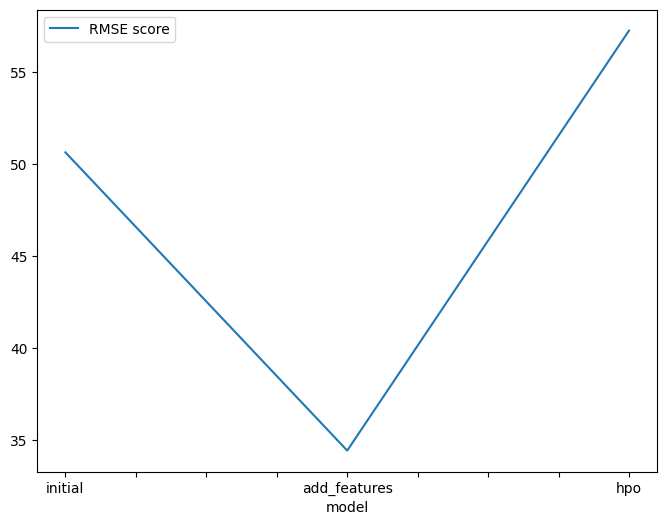

In [77]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [50.622477, 34.417474, 57.238104]
    }
).plot(x="model", y="score", figsize=(8, 6), label="RMSE score").get_figure()
fig.savefig('img/model_train_score.png')

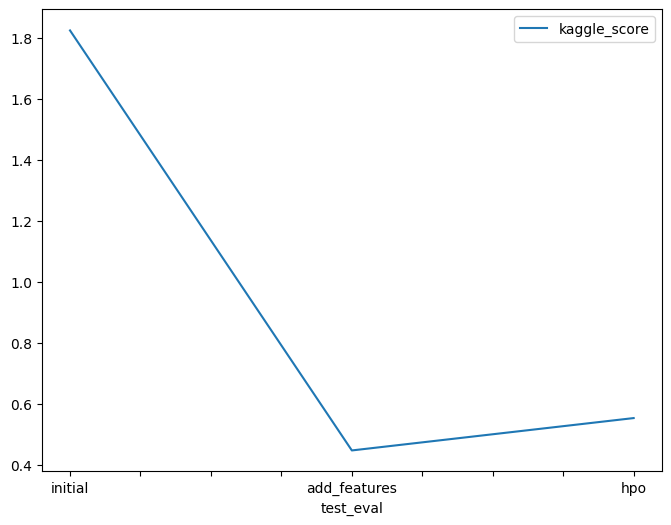

In [78]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.82602, 0.44715, 0.55340]
    }
).plot(x="test_eval", y="score", figsize=(8, 6), label="kaggle_score").get_figure()
fig.savefig('img/model_test_score.png')